In [205]:
# Import all the goods
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
plt.style.use('seaborn-whitegrid')

# Import the data files
xl_01 = pd.ExcelFile('20190927_HeartSurvey_edited.xlsx')
survey = xl_01.parse("Sheet1")
xl_02 = pd.ExcelFile('Survey questions key.xlsx')
survey_key = xl_02.parse("Sheet1")

## Extract observer risk scores to its own dataframe
risk = survey.iloc[:, 10:130:2].fillna(50).T ## All the actual questions, risk value
## Rename columns to match observer ID
risk.columns = [i+1 for i in range(12)]
## Rename indices to actual numbers, instead of the crazy codes
risk.index = [i for i in range(60)]

## Extract waitlist decision data to its own dataframe
decision = survey.iloc[:, 11:130:2].T ## All the actual questions, risk value
## Rename waitlist decision columns to match the risk columns
decision.columns = [i+1 for i in range(12)]

## Extract SRTR Risk scores
srtr_risk = pd.DataFrame(survey_key["SRTR Risk"])
## Create a scaled SRTR Risk key
scaler = MinMaxScaler(feature_range=(0,100))
scaled_srtr_risk = scaler.fit_transform(srtr_risk)
scaled_srtr_risk = pd.DataFrame(scaled_srtr_risk, columns=['Scaled SRTR Risk'])

# Create a master dataframe
## Add to the observer risk dataframe SRTR scores and Question IDs as extra columns
risk.insert(0,'Scaled SRTR Risk', scaled_srtr_risk)
risk.insert(0,'SRTR Risk', srtr_risk)
risk.insert(0,'Scenario ID', [i+1 for i in range(60)])
## Unpivot the observer risk dataframe
data_temp = pd.melt(risk, id_vars=['Scenario ID', 'SRTR Risk', 'Scaled SRTR Risk'], var_name='Observer ID', value_name='Observer Risk')
## Add to the unpivoted table all the decisions
data_temp.insert(0,'Observer Decision', pd.melt(decision).value)
## Finally, reorganize the columns
master_data = data_temp[['Scenario ID', 'SRTR Risk', 'Scaled SRTR Risk', 'Observer ID', 'Observer Risk', 'Observer Decision']]

master_data.head()

,Scenario ID,SRTR Risk,Scaled SRTR Risk,Observer ID,Observer Risk,Observer Decision
0,1,15.51,46.304263,1,50.0,Yes
1,2,26.40,88.893234,1,92.0,No
2,3,7.36,14.430974,1,63.0,Yes
3,4,4.01,1.329683,1,0.0,Yes
4,5,3.67,0.000000,1,100.0,No


Text(0.5,0,'Risk Score')

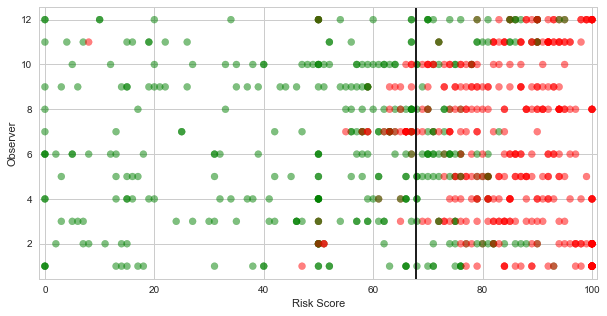

In [110]:
# All scenarios stacked into one chart, with a Mean of Means line thrown in
plt.rcParams['figure.figsize'] = [10, 5]
x = master_data['Observer Risk']
y = master_data['Observer ID']
colors = master_data['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])

plt.scatter(x, y, marker='o', color=colors, alpha=0.5)
plt.axvline(x=master_data['Observer Risk'].mean(), color='black')
plt.xlim(-1, 101)
plt.ylabel('Observer')
plt.xlabel('Risk Score')


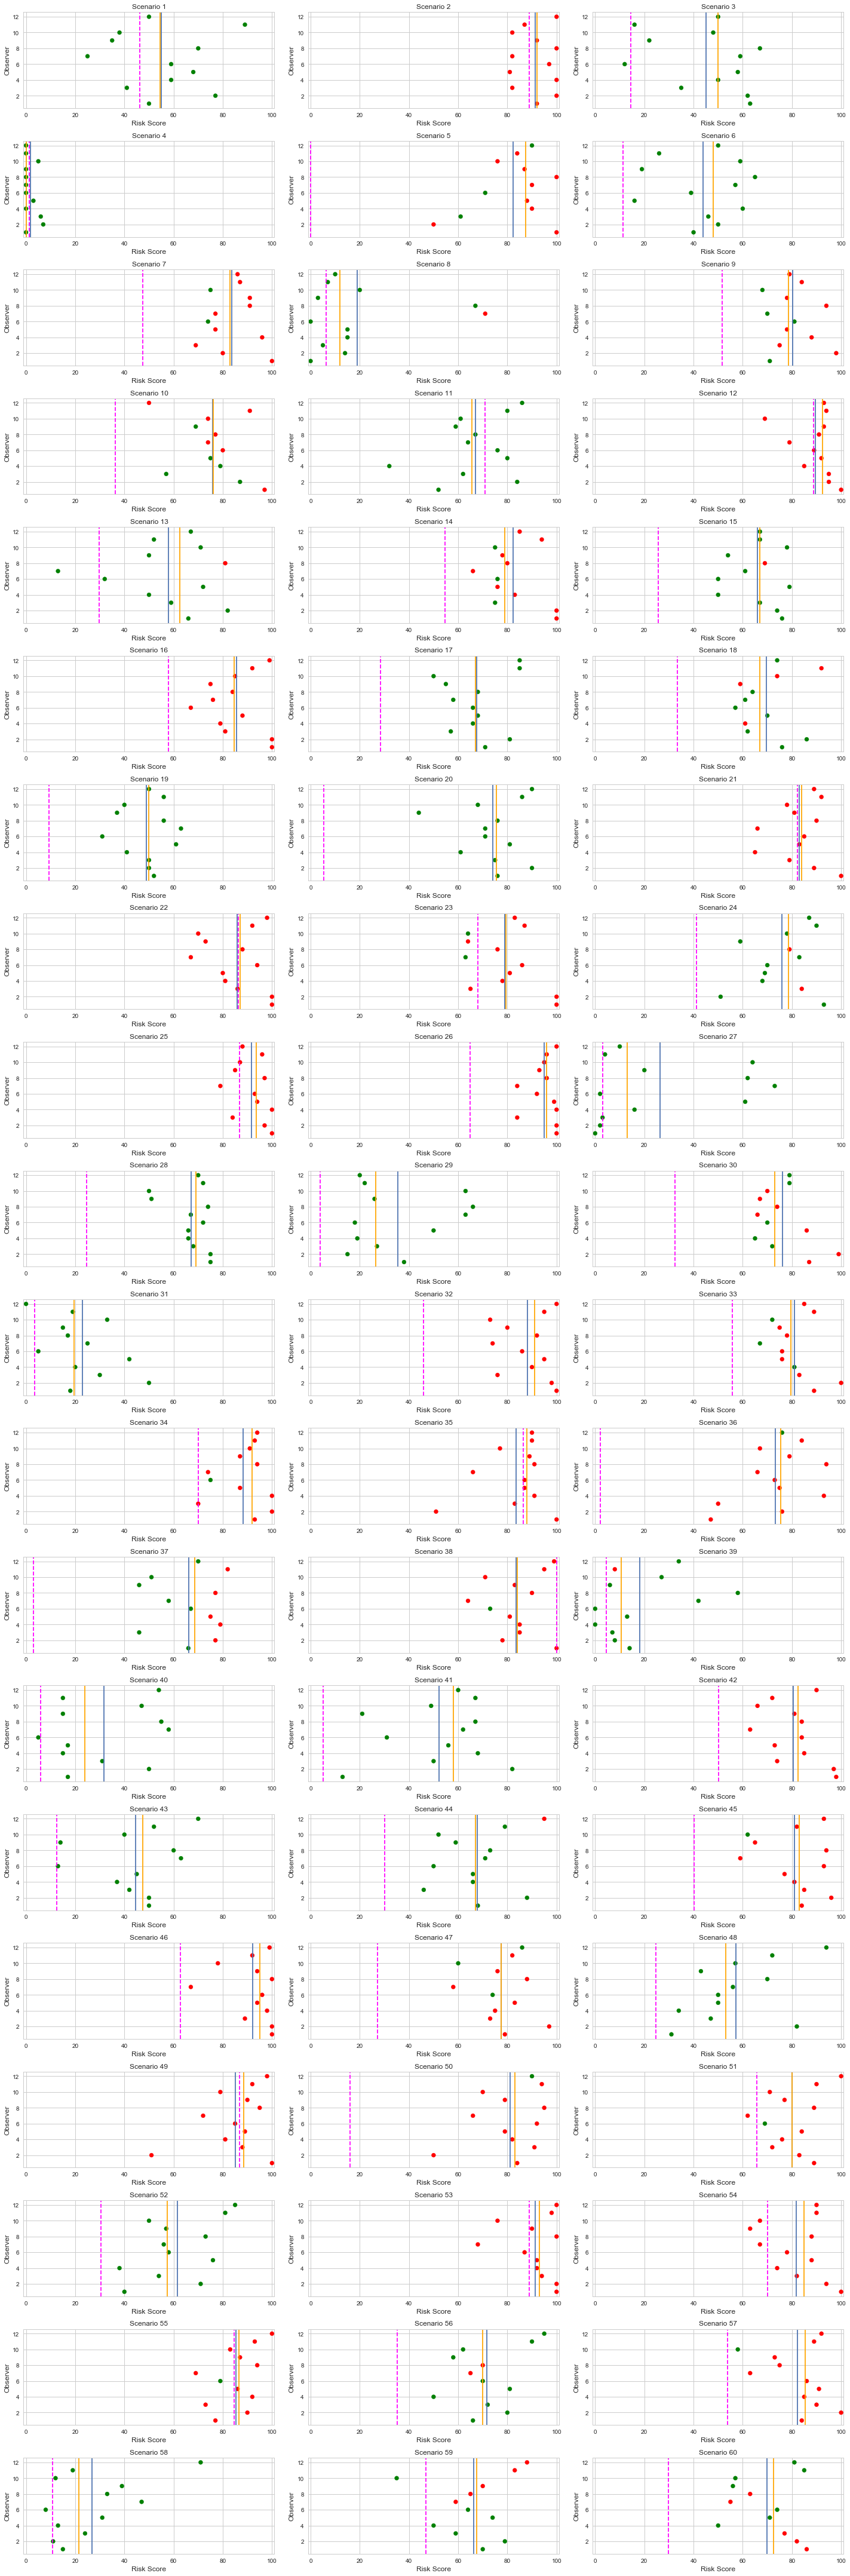

In [225]:
## Plot observer risk/decision for each scenario
#    Mean = blue line
#    Median = orange line
#    Scaled SRTR risk = dotted magenta line

def plotAllScenarios(df):
    plt.rcParams['figure.figsize'] = [20, 60]
    fig, axs = plt.subplots(20, 3)
    scenario = 1
    for i in range(20):
        for j in range(3):
            risk     = df[df['Scenario ID'] == scenario]['Observer Risk']
            observer = df[df['Scenario ID'] == scenario]['Observer ID']
            colors   = df[df['Scenario ID'] == scenario]['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])
            srtr     = df[df['Scenario ID'] == scenario]['Scaled SRTR Risk'].max()
            axs[i, j].set_xlim([-1, 101])
            axs[i, j].scatter(risk, observer, color=colors)
            axs[i, j].axvline(x=risk.mean())
            axs[i, j].axvline(x=risk.median(), color='orange')
            axs[i, j].axvline(x=srtr, color='magenta', linestyle='--')
            axs[i, j].set_title(f'Scenario {scenario}', fontsize='large')
            axs[i, j].set_ylabel('Observer', fontsize='large')
            axs[i, j].set_xlabel('Risk Score', fontsize='large')
            scenario += 1
    plt.tight_layout()
    
plotAllScenarios(master_data)

In [152]:
results_a = master_data.loc[(master_data['Scenario ID'] <= 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]
results_b = master_data.loc[(master_data['Scenario ID'] > 30)][['Scenario ID', 'Observer Risk', 'Scaled SRTR Risk']]

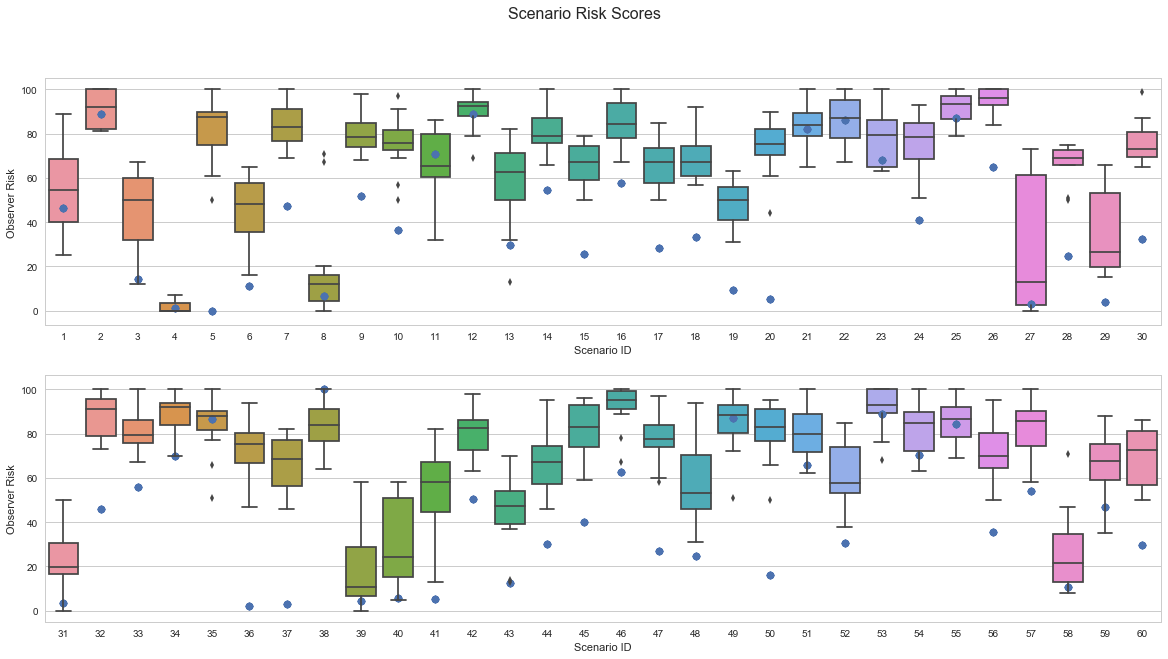

In [309]:
## Box plot
#  Shows median, 1.5 interquartile range, and range of scores for each scenario
#  Scaled SRTR Score = blue dot

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_a)
ax_1 = plt.scatter(results_a['Scenario ID']-1, results_a['Scaled SRTR Risk'])

plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_b)
ax_2 = plt.scatter(results_b['Scenario ID']-31, results_b['Scaled SRTR Risk'])

plt.suptitle('Scenario Risk Scores', fontsize=16)

plt.savefig('plot_BoxPerScenario.jpg')

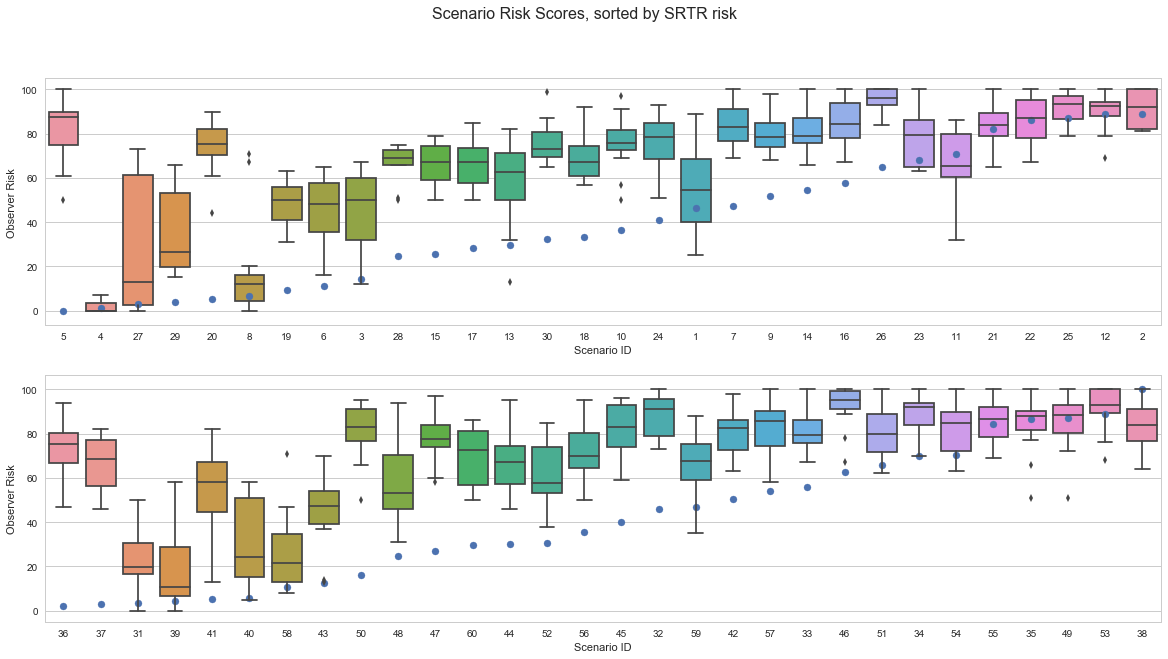

In [307]:
## Same as above, but sorted by increasing SRTR risk score

plt.figure(figsize=(20, 10))

sorted_results_a = results_a.sort_values('Scaled SRTR Risk')[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()['Scenario ID']
sorted_srtr_a = results_a[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates().sort_values('Scaled SRTR Risk')
sorted_results_b = results_b.sort_values('Scaled SRTR Risk')[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()['Scenario ID']
sorted_srtr_b = results_b[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates().sort_values('Scaled SRTR Risk')

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_a, order=sorted_results_a)
ax_1 = plt.scatter([i for i in range(30)], sorted_srtr_a['Scaled SRTR Risk'])

plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_b, order=sorted_results_b)
ax_2 = plt.scatter([i for i in range(30)], sorted_srtr_b['Scaled SRTR Risk'])

plt.suptitle('Scenario Risk Scores, sorted by SRTR risk', fontsize=16)

plt.savefig('plot_BoxPerScenario_sortSRTR.jpg')

In [ ]:
###################   START HERE!!!   ###########################

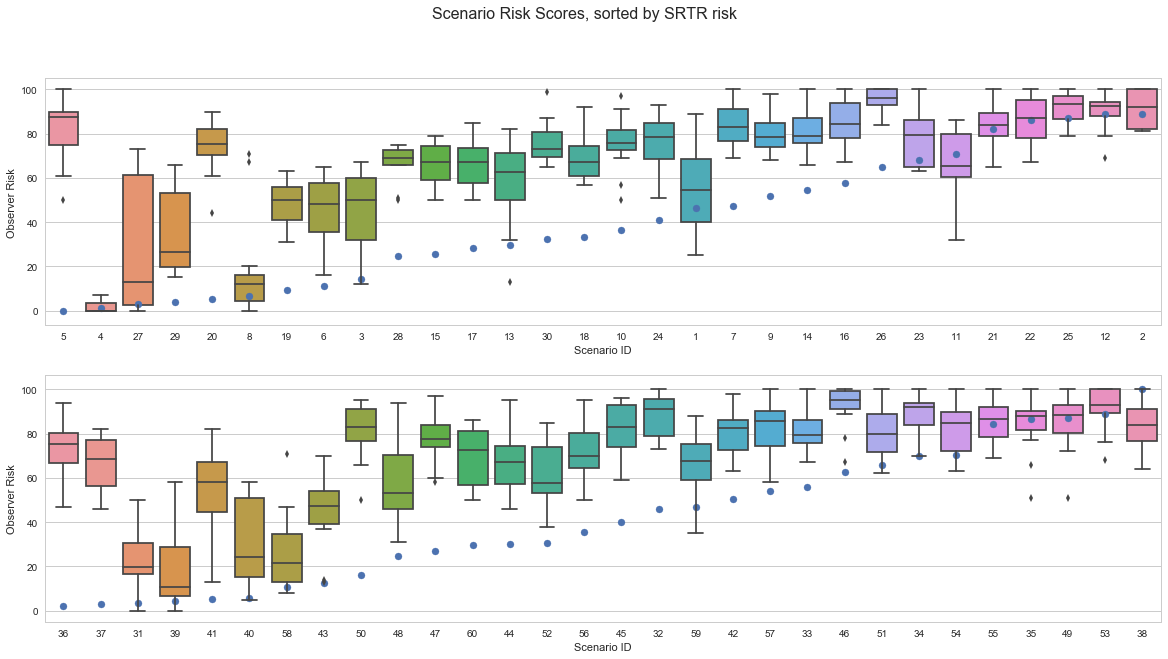

In [307]:
## Same as above, but sorted by increasing observer mean risk score

plt.figure(figsize=(20, 10))

sorted_results_a = results_a.sort_values('Scaled SRTR Risk')[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()['Scenario ID']
sorted_srtr_a = results_a[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates().sort_values('Scaled SRTR Risk')
sorted_results_b = results_b.sort_values('Scaled SRTR Risk')[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates()['Scenario ID']
sorted_srtr_b = results_b[['Scenario ID', 'Scaled SRTR Risk']].drop_duplicates().sort_values('Scaled SRTR Risk')

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_a, order=sorted_results_a)
ax_1 = plt.scatter([i for i in range(30)], sorted_srtr_a['Scaled SRTR Risk'])

plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(x='Scenario ID', y='Observer Risk', data=results_b, order=sorted_results_b)
ax_2 = plt.scatter([i for i in range(30)], sorted_srtr_b['Scaled SRTR Risk'])

plt.suptitle('Scenario Risk Scores, sorted by SRTR risk', fontsize=16)

plt.savefig('plot_BoxPerScenario_sortSRTR.jpg')

In [316]:
results_a.groupby('Scenario ID').mean().sort_values('Observer Risk')

,Observer Risk,Scaled SRTR Risk
Scenario ID,,
4,1.750000,1.329683
8,18.916667,6.413766
27,26.416667,3.128666
29,35.583333,3.871725
6,43.916667,11.302307
3,45.166667,14.430974
19,48.916667,9.268674
1,55.083333,46.304263
13,57.916667,29.839656


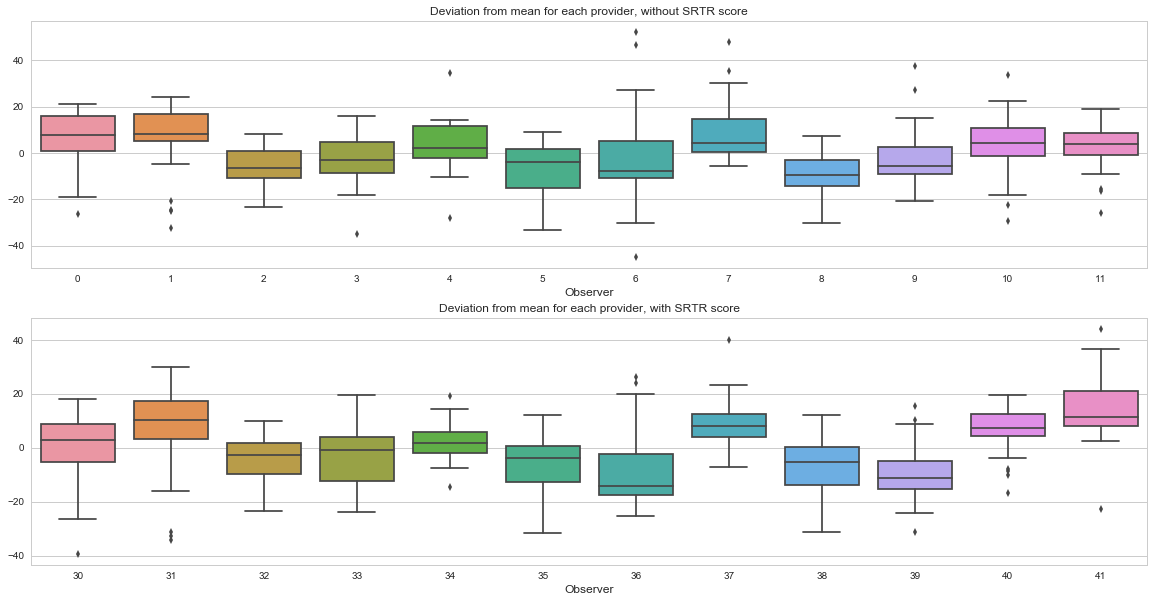

In [226]:
## Box plot
#  Shows median, 1.5 interquartile range, and range of scores for each scenario
observer_risk = risk[[i+1 for i in range(12)]].T

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
ax_1 = sns.boxplot(data=(observer_risk.iloc[:, 0:30] - observer_risk.iloc[:, 0:30].mean()).T)
ax_1.set_xticklabels(observer_risk.iloc[:, 0:30].columns.values)
ax_1.set_xlabel('Observer', fontsize='large')
ax_1.title.set_text('Deviation from mean for each provider, without SRTR score')

plt.subplot(2, 1, 2)
ax_2 = sns.boxplot(data=(observer_risk.iloc[:, 30:60] - observer_risk.iloc[:, 30:60].mean()).T)
ax_2.set_xticklabels(observer_risk.iloc[:, 30:60].columns.values)
ax_2.set_xlabel('Observer', fontsize='large')
ax_2.title.set_text('Deviation from mean for each provider, with SRTR score');

#plt.savefig('plot2.jpg')

Text(0,0.5,'Observer Risk Score')

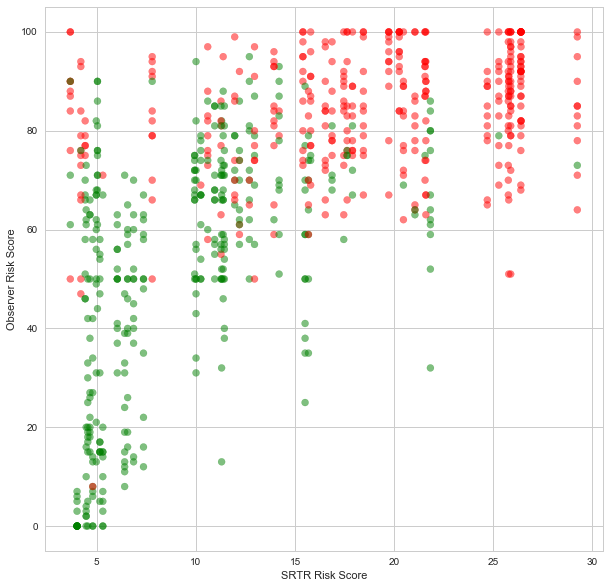

In [236]:
colors = master_data['Observer Decision'].replace(['Yes', 'No'], ['green', 'red'])

plt.figure(figsize=(10, 10))
plt.scatter(master_data['SRTR Risk'], master_data['Observer Risk'], color=colors, alpha=0.5)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')

Text(0,0.5,'Observer Risk Score')

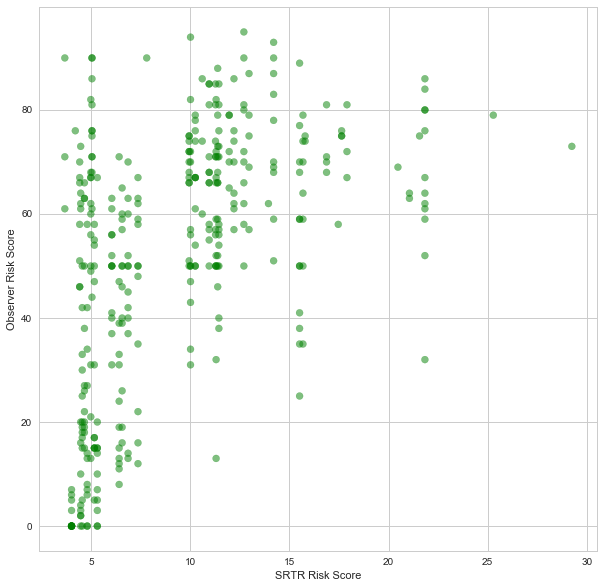

In [235]:
decision_yes = master_data['Observer Decision'] == 'Yes'

plt.figure(figsize=(10, 10))
plt.scatter(master_data[decision_yes]['SRTR Risk'], master_data[decision_yes]['Observer Risk'], color=colors[decision_yes], alpha=0.5)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')

Text(0,0.5,'Observer Risk Score')

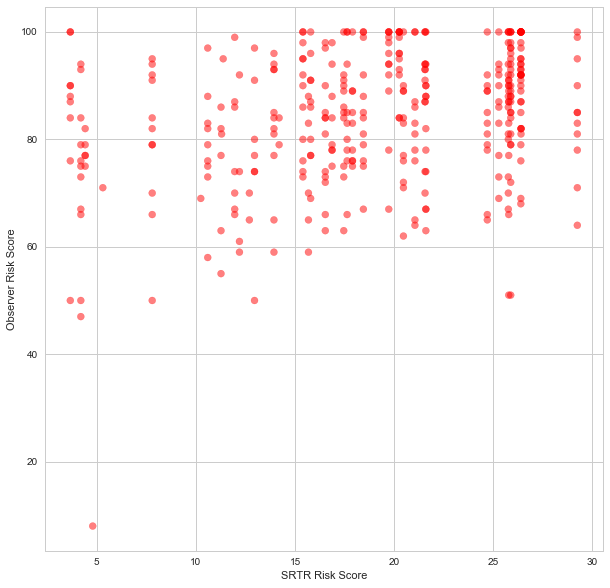

In [240]:
decision_no = master_data['Observer Decision'] == 'No'

plt.figure(figsize=(10, 10))
plt.scatter(master_data[decision_no]['SRTR Risk'], master_data[decision_no]['Observer Risk'], color=colors[decision_no], alpha=0.5)
plt.xlabel('SRTR Risk Score')
plt.ylabel('Observer Risk Score')

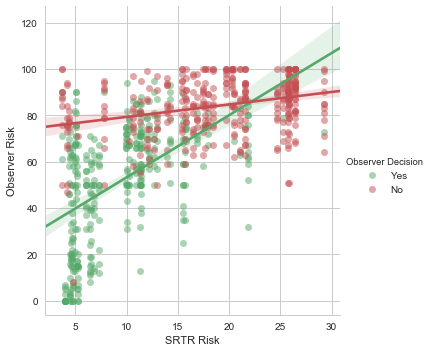

In [257]:
fit_all = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data, hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5})

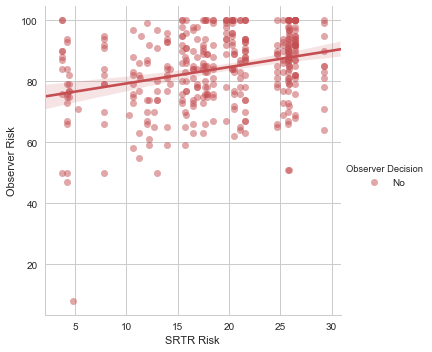

In [247]:
fit_no = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_no], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5})

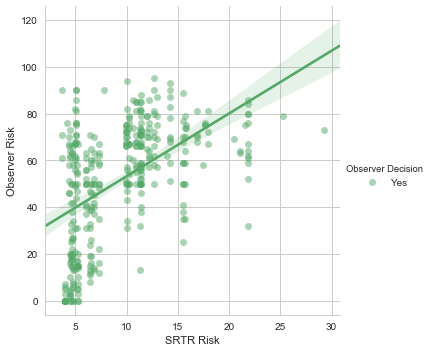

In [248]:
fit_yes = sns.lmplot(x="SRTR Risk", y="Observer Risk", data=master_data[decision_yes], hue="Observer Decision", palette=dict(Yes="g", No="r"), scatter_kws={'alpha':0.5})